In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("ab_browser_test.csv")

In [3]:
sum_1 = df[df.slot == "exp"].n_clicks.sum()
sum_2 = df[df.slot == "control"].n_clicks.sum()
print (float(sum_1)/sum_2 - 1) * 100

1.6135689824415822


In [4]:
def get_bootstrap_samples(data, n_samples):
    data_length = len(data)
    indices = np.random.randint(0, data_length, (n_samples, data_length))
    return data[indices]
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
def median_conf_int(data, n_samples = 1000, alpha = 0.05):
    median = np.median(data)
    medians = map(lambda samples: np.median(samples), get_bootstrap_samples(data, n_samples))
    confint = stat_intervals(medians, alpha)
    return (median, confint)
def diff_median_conf_int(data_1, data_2, n_samples, alpha):
    median_1 = map(lambda samples: np.median(samples), get_bootstrap_samples(data_1, n_samples))
    median_2 = map(lambda samples: np.median(samples), get_bootstrap_samples(data_2, n_samples))
    return stat_intervals(map(lambda (s_median,d_median): s_median-d_median, zip(median_1, median_2)), alpha)
def mean_conf_int(data, n_samples = 1000, alpha = 0.05):
    mean = np.mean(data)
    means = map(lambda samples: np.mean(samples), get_bootstrap_samples(data, n_samples))
    confint = stat_intervals(means, alpha)
    return (mean, confint)
def diff_mean_conf_int(data_1, data_2, n_samples, alpha):
    mean_1 = map(lambda samples: np.mean(samples), get_bootstrap_samples(data_1, n_samples))
    mean_2 = map(lambda samples: np.mean(samples), get_bootstrap_samples(data_2, n_samples))
    return stat_intervals(map(lambda (s_mean,d_mean): s_mean-d_mean, zip(mean_1, mean_2)), alpha)

In [5]:
import numpy as np
df_0 = df[df.slot == "exp"]
df_1 = df[df.slot == "control"]
n_samples = 1000
alpha = 0.05
print diff_median_conf_int(df_0["n_clicks"].values, df_1["n_clicks"].values, n_samples, alpha)
print diff_mean_conf_int(df_0["n_clicks"].values, df_1["n_clicks"].values, n_samples, alpha)

[1. 1.]
[0.20305813 0.4089392 ]


In [6]:
from scipy import stats
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


([array([1.81467e+05, 4.54490e+04, 1.92750e+04, 1.22830e+04, 7.47500e+03,
         4.29700e+03, 3.23300e+03, 2.19100e+03, 1.36700e+03, 1.07900e+03,
         7.21000e+02, 5.82000e+02, 4.39000e+02, 2.70000e+02, 3.08000e+02,
         2.17000e+02, 1.51000e+02, 1.17000e+02, 1.02000e+02, 9.30000e+01,
         9.10000e+01, 6.00000e+01, 4.20000e+01, 4.60000e+01, 3.00000e+01,
         2.50000e+01, 1.20000e+01, 2.20000e+01, 1.50000e+01, 1.30000e+01,
         8.00000e+00, 1.60000e+01, 1.00000e+01, 1.00000e+01, 3.00000e+00,
         5.00000e+00, 5.00000e+00, 2.00000e+00, 4.00000e+00, 7.00000e+00,
         3.00000e+00, 4.00000e+00, 5.00000e+00, 0.00000e+00, 2.00000e+00,
         0.00000e+00, 2.00000e+00, 1.00000e+00, 4.00000e+00, 1.00000e+00,
         0.00000e+00, 0.00000e+00, 0.00000e+00, 4.00000e+00, 0.00000e+00,
         0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
         0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00,
         0.00000e+00, 1.00000e+00, 0.0

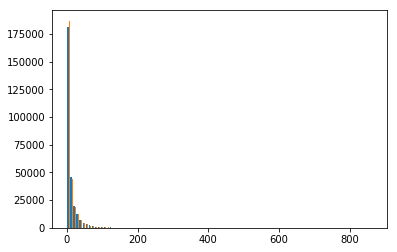

In [7]:
pylab.hist([df_0.n_clicks, df_1.n_clicks], 100, label = ["0", "1"])

In [8]:
from statsmodels.sandbox.stats.multicomp import multipletests
exp_browser_names = set(df_0["browser"])
exp_browser_data = {}
for browser_name in exp_browser_names:
    exp_browser_data[browser_name] = df_0[df_0["browser"]==browser_name]
control_browser_names = set(df_1["browser"])
control_browser_data = {}
for browser_name in control_browser_names:
    control_browser_data[browser_name] = df_1[df_1["browser"]==browser_name]
all_browser_names = exp_browser_names.union(control_browser_names)
mann_whitney_pvalues = []
for browser_name in all_browser_names:
    exp_b_user_clicks = exp_browser_data[browser_name]["n_clicks"].values
    control_b_user_clicks = control_browser_data[browser_name]["n_clicks"].values
    mann_whitney_stat = stats.mannwhitneyu(control_b_user_clicks, exp_b_user_clicks, alternative="two-sided")
    mann_whitney_pvalues.append(mann_whitney_stat.pvalue)
mann_whitney_pvalues_corrected = multipletests(mann_whitney_pvalues, alpha = 0.05, method = 'holm')
for b in zip(all_browser_names, mann_whitney_pvalues_corrected[0]):
    print "%s is statistically valuable: %r" % b
print "Count of not rejected hypothesis: %i" % len(filter(lambda x: not(x), mann_whitney_pvalues_corrected[0]))

Browser #2 is statistically valuable: False
Browser #4 is statistically valuable: False
Browser #22 is statistically valuable: False
Browser #20 is statistically valuable: False
Browser #17 is statistically valuable: False
Browser #14 is statistically valuable: True
Count of not rejected hypothesis: 5


In [9]:
for browser_name in all_browser_names:
    exp_no_click_count = float(exp_browser_data[browser_name]["n_nonclk_queries"].sum())
    exp_queries_count = float(exp_browser_data[browser_name]["n_queries"].sum())
    control_no_click_count = float(control_browser_data[browser_name]["n_nonclk_queries"].sum())
    control_queries_count = float(control_browser_data[browser_name]["n_queries"].sum())
    exp_percent = exp_no_click_count/exp_queries_count*100
    control_percent = control_no_click_count/control_queries_count*100
    print "%s no click queries percentage: exp=%f\tcontrol=%f\tdiff=%f" % (browser_name, exp_percent, control_percent, (control_percent-exp_percent))



Browser #2 no click queries percentage: exp=44.982747	control=45.962747	diff=0.980000
Browser #4 no click queries percentage: exp=45.142942	control=46.970930	diff=1.827988
Browser #22 no click queries percentage: exp=39.853947	control=40.593977	diff=0.740029
Browser #20 no click queries percentage: exp=38.977376	control=40.540485	diff=1.563108
Browser #17 no click queries percentage: exp=36.937413	control=36.299367	diff=-0.638046
Browser #14 no click queries percentage: exp=43.755617	control=57.590411	diff=13.834794


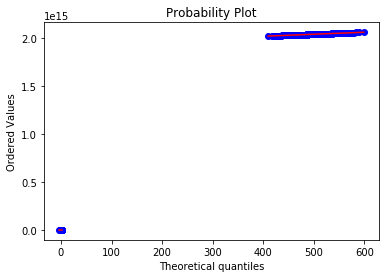

In [11]:
control_clicks = get_bootstrap_samples(df_1["n_clicks"].values, 500)
from scipy import stats
def calc_chisquare_stats(sample):
    mean = np.mean(sample)
    sample_size = len(sample)
    expected_means = [mean for x in xrange(0, sample_size)]
    stat = stats.chisquare(sample_size, expected_means, ddof=0, axis=0)
    return (mean, stat.statistic, stat.pvalue)
control_clicks_chi = map(calc_chisquare_stats, control_clicks)
#%%
mean_plot = stats.probplot(map(lambda (m,s,p): m, control_clicks_chi), dist = "norm", plot = pylab)
#%%
stat_plot = stats.probplot(map(lambda (m,s,p): s, control_clicks_chi), dist = "chi2", sparams=(500-1), plot = pylab)

In [12]:
print "Mean R^2: %f" % mean_plot[1][2]
print "Chi square R^2: %f" % stat_plot[1][2]

Mean R^2: 0.998524
Chi square R^2: 0.999031


In [13]:
mean_plot

((array([-2.99209858e+00, -2.71015927e+00, -2.55162541e+00, -2.43921385e+00,
         -2.35113311e+00, -2.27822091e+00, -2.21572267e+00, -2.16084152e+00,
         -2.11178767e+00, -2.06734403e+00, -2.02664403e+00, -1.98904794e+00,
         -1.95406954e+00, -1.92133033e+00, -1.89052965e+00, -1.86142459e+00,
         -1.83381593e+00, -1.80753820e+00, -1.78245240e+00, -1.75844061e+00,
         -1.73540186e+00, -1.71324904e+00, -1.69190643e+00, -1.67130780e+00,
         -1.65139483e+00, -1.63211595e+00, -1.61342528e+00, -1.59528183e+00,
         -1.57764883e+00, -1.56049314e+00, -1.54378481e+00, -1.52749667e+00,
         -1.51160399e+00, -1.49608418e+00, -1.48091659e+00, -1.46608224e+00,
         -1.45156367e+00, -1.43734479e+00, -1.42341071e+00, -1.40974764e+00,
         -1.39634279e+00, -1.38318426e+00, -1.37026095e+00, -1.35756253e+00,
         -1.34507932e+00, -1.33280226e+00, -1.32072287e+00, -1.30883317e+00,
         -1.29712567e+00, -1.28559331e+00, -1.27422944e+00, -1.26302778e+00,

In [14]:
exp_browser_names = set(df_0["browser"])
exp_browser_data = {}
for browser_name in exp_browser_names:
    exp_browser_data[browser_name] = df_0[df_0["browser"]==browser_name]
exp_browser_data

{'Browser #14':         userID      browser slot  n_clicks  n_queries  n_nonclk_queries
 8           13  Browser #14  exp         2          4                 3
 20          30  Browser #14  exp         4          4                 0
 23          33  Browser #14  exp        22          9                 2
 35          45  Browser #14  exp         5          8                 6
 73          83  Browser #14  exp         0          1                 1
 80          91  Browser #14  exp        21         27                16
 92         104  Browser #14  exp         4          1                 0
 94         106  Browser #14  exp         0          3                 3
 150        162  Browser #14  exp         0          1                 1
 155        167  Browser #14  exp        11         15                 6
 204        217  Browser #14  exp         8          9                 4
 211        224  Browser #14  exp        12          1                 0
 216        229  Browser #14  exp   

In [20]:
len(exp_browser_data['Browser #14']["n_clicks"].values)

44220

In [18]:
control_browser_data = {}
for browser_name in control_browser_names:
    control_browser_data[browser_name] = df_1[df_1["browser"]==browser_name]